In [2]:
%matplotlib inline


# Wind and Sea Level Pressure Interpolation

Interpolate sea level pressure, as well as wind component data,
to make a consistent looking analysis, featuring contours of pressure and wind barbs.

Adapted from: https://unidata.github.io/MetPy/latest/examples/gridding/Wind_SLP_Interpolation.html


In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.interpolate import interpolate_to_grid, remove_nan_observations
from metpy.plots import add_metpy_logo
from metpy.units import units
from metpy.io import metar

#to_proj = ccrs.AlbersEqualArea(central_longitude=-97., central_latitude=38.)
to_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

Read in data



In [4]:
## define the time we're plotting
datetime = pd.Timestamp(2021, 12, 11, 3)  ## year, month, day, hour, (minute, second)

In [5]:
#data = metar.parse_metar_file('metar_20211211_0300.txt')
data = metar.parse_metar_file("metar_"+datetime.strftime("%Y%m%d_%H%M")+".txt")

# Drop rows with missing winds
data = data.dropna(how='any', subset=['wind_direction', 'wind_speed'])

Take a quick look at the data we're using:

In [6]:
data

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,visibility,current_wx1,current_wx2,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
KC62,KC62,41.470000,-85.27,306.0,2022-01-11 02:55:00,160.0,11.0,4023.360,-RA,NaN,...,10.0,10.0,29.63,61,0,0,AO2 T01010101,1004.13,-3.762222e+00,10.336619
KFDW,KFDW,34.320000,-81.12,176.0,2022-01-11 02:55:00,130.0,4.0,402.336,FG,NaN,...,10.0,10.0,30.11,45,0,0,AO1,1020.30,-3.064178e+00,2.571150
KBRY,KBRY,37.816667,-85.50,204.0,2022-01-11 02:55:00,180.0,10.0,16093.440,NaN,NaN,...,17.0,16.0,29.73,0,0,0,AO1,1006.81,-1.224647e-15,10.000000
KW63,KW63,36.600000,-78.57,128.0,2022-01-11 02:55:00,0.0,0.0,16093.440,NaN,NaN,...,12.0,9.0,30.09,0,0,0,AO1,1019.42,-0.000000e+00,-0.000000
KLBE,KLBE,40.270000,-79.40,361.0,2022-01-11 02:50:00,0.0,0.0,16093.440,NaN,NaN,...,13.0,8.0,29.91,0,0,0,,1013.28,-0.000000e+00,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KTCM,KTCM,47.120000,-122.47,98.0,2022-01-11 03:10:00,190.0,15.0,11265.408,NaN,NaN,...,7.0,4.0,29.87,0,0,0,AO2A RAB0257E10RAB10 SLP121 RVRNO $,1012.13,2.604723e+00,14.772116
KBEA,KBEA,28.370000,-97.78,82.0,2022-01-11 03:15:00,160.0,6.0,16093.440,NaN,NaN,...,22.0,22.0,29.78,0,0,0,AO2 T02230215,1008.51,-2.052121e+00,5.638156
KBKS,KBKS,27.200000,-98.12,34.0,2022-01-11 03:15:00,180.0,7.0,16093.440,NaN,NaN,...,23.0,21.0,29.78,0,0,0,AO2 T02270212,1008.65,-8.572528e-16,7.000000


This METAR dataset includes surface data from around the world, but the interpolation method can sometimes fail when getting close to the poles, etc. So we'll subset the data down to the general region of North America. 

In [7]:
## subset to -50 to -150 longitude and 15-70 latitude 
data = data[(data.longitude < -50) & (data.longitude > -150) & (data.latitude > 15) & (data.latitude < 70)]

Project the lon/lat locations to our final projection



In [8]:
lon = data['longitude'].values
lat = data['latitude'].values
xp, yp, _ = to_proj.transform_points(ccrs.Geodetic(), lon, lat).T

Remove all missing data from pressure



In [9]:
x_masked, y_masked, pressure = remove_nan_observations(xp, yp, data['air_pressure_at_sea_level'].values)

Interpolate pressure using Cressman interpolation



In [10]:
slpgridx, slpgridy, slp = interpolate_to_grid(x_masked, y_masked, pressure,
                                              interp_type='cressman', minimum_neighbors=1,
                                              search_radius=400000, hres=100000)

Get wind information and mask where either speed or direction is unavailable



In [11]:
wind_speed = (data['wind_speed'].values * units('m/s')).to('knots')
wind_dir = data['wind_direction'].values * units.degree

good_indices = np.where((~np.isnan(wind_dir)) & (~np.isnan(wind_speed)))

x_masked = xp[good_indices]
y_masked = yp[good_indices]
wind_speed = wind_speed[good_indices]
wind_dir = wind_dir[good_indices]

Calculate u and v components of wind and then interpolate both.

Both will have the same underlying grid so throw away grid returned from v interpolation.



In [12]:
u, v = wind_components(wind_speed, wind_dir)

windgridx, windgridy, uwind = interpolate_to_grid(x_masked, y_masked, np.array(u),
                                                  interp_type='cressman', search_radius=400000,
                                                  hres=100000)

_, _, vwind = interpolate_to_grid(x_masked, y_masked, np.array(v), interp_type='cressman',
                                  search_radius=400000, hres=100000)

Get temperature information



In [13]:
x_masked, y_masked, t = remove_nan_observations(xp, yp, data['air_temperature'].values)
tempx, tempy, temp = interpolate_to_grid(x_masked, y_masked, t, interp_type='cressman',
                                         minimum_neighbors=3, search_radius=400000, hres=35000)

temp = np.ma.masked_where(np.isnan(temp), temp)

Set up the map and plot the interpolated grids appropriately.



/Users/rschumac/opt/miniforge3/envs/ats641_2022/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/rschumac/opt/miniforge3/envs/ats641_2022/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/rschumac/opt/miniforge3/envs/ats641_2022/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

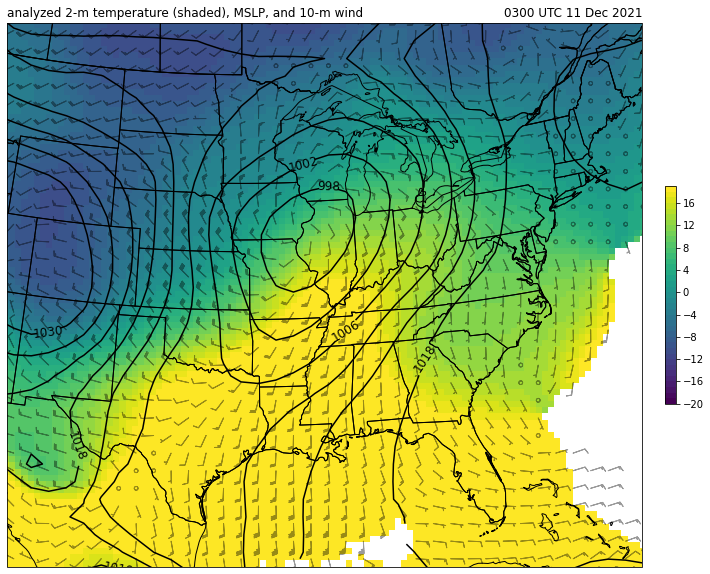

In [14]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
#add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=to_proj)

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

# Set plot bounds
#ax.set_extent((-118, -73, 23, 50))
ax.set_extent((-108,-73, 23, 50))


levels = list(range(-20, 20, 1))
cmap = plt.get_cmap('viridis')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

cs = ax.contour(slpgridx, slpgridy, slp, colors='k', levels=list(range(990, 1034, 4)))
ax.clabel(cs, inline=1, fontsize=12, fmt='%i')

mmb = ax.pcolormesh(tempx, tempy, temp, cmap=cmap, norm=norm)
fig.colorbar(mmb, shrink=.4, pad=0.02, boundaries=levels)

ax.barbs(windgridx, windgridy, uwind, vwind, alpha=.4, length=5)

plt.title('analyzed 2-m temperature (shaded), MSLP, and 10-m wind', loc='left')
plt.title(datetime.strftime("%H%M UTC %d %b %Y"), loc='right')


plt.show()

In [15]:
fig.savefig("sfc_analysis_test.png", bbox_inches='tight', facecolor='white', transparent=False)